In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None) # will display full text in row
from collections import defaultdict
import numpy as np
import os, re, string
from time import time
from clean_text import clean_text
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import corpus_bleu
import seaborn as sns
import matplotlib.pyplot as plt

## Get Covid Tweet dataset

In [2]:
# Download data from https://www.kaggle.com/datatattle/covid-19-nlp-text-classification?select=Corona_NLP_train.csv
train = pd.read_csv('../datasets/Corona_NLP_train.csv', encoding='ISO-8859-1')
test = pd.read_csv('../datasets/Corona_NLP_test.csv', encoding='ISO-8859-1')
print(train.shape)
print(test.shape)

(41157, 6)
(3798, 6)


### Combine train and test, since we're using an unsupervised model

In [3]:
data = pd.concat([train, test], axis=0)
del train, test

In [4]:
# Restrict to useful columns
data = data[['Location', 'TweetAt', 'OriginalTweet']].rename(columns={'TweetAt': 'Date', 'OriginalTweet': 'Tweet'})

In [5]:
# Shuffle data for good measure
data = data.sample(frac=0.01, random_state=123).reset_index(drop=True)

In [6]:
data.head()

,Location,Date,Tweet
0,"London, UK",22-03-2020,"QPAY cuts POS prices by 50% to help Qatari SMEs fight CoVid-19: QPAY International, a member of the NEXXO Network, the leading financial technology (Fintech) company in Qatar servicing over 15,000 Qatari SmallÂ ... https://t.co/ufT6VKKXNd #fintech"
1,"Chicago, IL",18-03-2020,"According to a Mariano's employee who just got out of work and on my bus, a fight broke out in the grocery store, glass was broken. Stay safe y'all. #coronavirus #COVID19"
2,London,08-04-2020,Just had a text that reads: \r\r\n\r\r\nCONGRATULATIONS. YOU ARE NOW CLEAR TO LEAVE YOUR HOME AT ANY TIME AND LICK SUPERMARKET TROLLEY HANDLES. \r\r\n\r\r\nREGARDS BORIS JOHNSON\r\r\n\r\r\nPretty sure itÂs from my first wife. #LOCKDOWN #coronavirus
3,The World,25-03-2020,ArenÂt the prices of some vital products @costco extremely high? @USDAFoodSafety @USATODAY @LACountyDCBA @MayorOfLA @LANow #food #socal #coronavirus #COVID2019
4,"Auckland, New Zealand",22-03-2020,Security guards at the supermarket. WTF is wrong with people that requires guards to protect the poor checkout staff #Covid_19


In [7]:
data.shape

(450, 3)

## Data cleaning

### Fix tweets
I remove html, URLs, punctuation, hashtags, emoticons, convert contractions, remove stop words, lematize words, and convert everything to lowercase.

In [8]:
# Standardizd (somewhat) version of word `coronavirus`
def standardize_words(string):
    string = string.replace('COVID-19', 'coronavirus')
    string = string.replace("COVID 19" , 'coronavirus')
    string = string.replace("Covid-19", 'coronavirus')
    string = string.replace('COVID?19', 'coronavirus')
    string = string.replace('covid', 'coronavirus')
    string = string.replace('COVID', 'coronavirus')
    string = string.replace('Covid_19', 'coronavirus')
    string = string.replace('COVID2019', 'coronavirus')
    string = string.replace('coronavirus19', 'coronavirus')
    string = string.replace('COVID', 'coronavirus')
    string = string.replace('covid', 'coronavirus')
    return string

In [9]:
processed = pd.DataFrame(data['Tweet'].apply(lambda x: standardize_words(x)).rename('clean'))

In [10]:
start = time()
processed = pd.DataFrame(clean_text().run(processed['clean'], no_stop_words=True, 
                                          remove_punctuation=True, lemmatize=True).rename('clean'))
print('Total time:', round(time() - start, 0), 'seconds')

Total time: 3.0 seconds


In [11]:
processed.head()

,clean
0,qpay cut po price fifty help qatari smes fight covid nineteen qpay international member nexxo network lead financial technology fintech company qatar service zero qatari small
1,accord mariano employee get work bus fight broke grocery store glass broken stay safe
2,text read congratulation clear leave home time lick supermarket trolley handle regard boris johnson pretty sure first wife
3,price vital product extremely high
4,security guard supermarket wtf wrong people require guard protect poor checkout staff


#### Distribution of word frequencies in corpus

In [12]:
def count_word_freq(series):
    '''
    Counts word frequency across all documents (rows) in a pd.Series.
    :param series: pd.Series
    :returns: pd.DataFrame, where index is each unique word in corpus and column is count of
        the occurrence of that word across all documents.
    '''
    temp = [i.split() for i in series] 
    freq = defaultdict(int)  # Get freq of each word across all documents
    for indiv_doc in temp:
        for token in indiv_doc:
            freq[token] += 1
        
    word_freq = pd.DataFrame.from_dict(freq, orient='index')\
        .reset_index().rename(columns={'index': 'word', 0: 'freq'})
    return word_freq

In [13]:
word_freq = count_word_freq(processed['clean'])

In [14]:
print(word_freq['freq'].describe())

count    2516.000000
mean        2.955087
std         6.839888
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       141.000000
Name: freq, dtype: float64


In [15]:
print(f"Number of words that appear only once in corpus: {len(word_freq[word_freq['freq']==1])}")

Number of words that appear only once in corpus: 1529


In [16]:
print('Some examples of rare words:')
word_freq[word_freq['freq']==1]['word'].head(10)

Some examples of rare words:


2                po
7              smes
11    international
13            nexxo
14          network
17       technology
18          fintech
20            qatar
25          mariano
30            broke
Name: word, dtype: object

#### Correcting misspelled words

### Fix date

In [17]:
processed['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y', errors='coerce').dt.strftime("%Y-%m-%d")

In [18]:
print(processed['Date'].isnull().mean())

0.0


In [19]:
# Date range
for i in sorted(processed['Date'].unique()):
    print(i)

2020-03-04
2020-03-11
2020-03-12
2020-03-13
2020-03-14
2020-03-15
2020-03-16
2020-03-17
2020-03-18
2020-03-19
2020-03-20
2020-03-21
2020-03-22
2020-03-23
2020-03-24
2020-03-25
2020-03-26
2020-03-27
2020-03-28
2020-03-30
2020-03-31
2020-04-01
2020-04-02
2020-04-03
2020-04-04
2020-04-05
2020-04-06
2020-04-07
2020-04-08
2020-04-09
2020-04-10
2020-04-11
2020-04-12
2020-04-13
2020-04-14


### Fix location

In [20]:
print(data['Location'].nunique())
print(data['Location'].isnull().mean())

296
0.19555555555555557


In [21]:
data['Location'].head(10)

0                 London, UK
1                Chicago, IL
2                     London
3                  The World
4      Auckland, New Zealand
5                        NaN
6    West Yorkshire, England
7       ?Southern California
8       East Coast Australia
9            Minneapolis, MN
Name: Location, dtype: object

In [22]:
foo = data['Location'].str.replace("[^a-zA-Z ]", '', regex=True)
foo = foo.replace(np.NaN, '') # convert missings to empty strings
foo = foo.apply(lambda x: ' '.join(x.split())) # remove excess whitespace from some rows

In [23]:
states = pd.read_csv('../datasets/US States.csv')
print(states.head(5))

            State Abbreviation
0         ALABAMA           AL
1          ALASKA           AK
2  AMERICAN SAMOA           AS
3         ARIZONA           AZ
4        ARKANSAS           AR


In [24]:
states_dict = dict(zip(states['Abbreviation'].tolist(), states['State'].tolist()))

In [25]:
# Lookup function to replace state abbreviations with state names
def lookup_replace(col, dict_map):
    '''
    '''
    new = []
    for i in range(len(col)):
        tmp = []
        try:
            for word in col.iloc[i].split():
                if word in dict_map.keys():
                    name = dict_map[word]
                else:
                    name = word
                tmp.append(name)
        except AttributeError:
            tmp = np.NaN
        new.append(tmp)
    return pd.Series(new).apply(lambda x: ' '.join(x))

In [26]:
foo = lookup_replace(foo, states_dict)

In [27]:
foo.sample(n=20)

110           Westminster London
311               United Kingdom
224                      Ontario
333       San Francisco Bay Area
445            Basel Switzerland
222                 New York USA
38                         DCish
346                             
261                             
192                             
134                  Accra Ghana
267                             
344           Seattle WASHINGTON
409       England United Kingdom
95          Lake Station INDIANA
70     From Nola in another life
19                       Toronto
74                              
30                              
35          Boston MASSACHUSETTS
dtype: object

## Keywords using pretrained BERT model and cosine similarity

[Credit](https://towardsdatascience.com/keyword-extraction-with-bert-724efca412ea)

In [28]:
%%capture
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [29]:
def bert_keywords(col, n_keywords=5, ngram_range=(1, 1)):
    '''
    Uses pretrained BERT model from sentence-transformer to generate nth keywords per document.
    :param col:, pd.Series, input (cleaned) text, one document per row
    :param n_keywords: int, number of top keywords per document to return.
    :param ngram_range: tuple, ngram range, e.g. (1,1) is monogram, (2,2) is bigram.
    :returns: pd.Series of lists, where each sublist contains top keywords per document
    '''
    keyword_list = []
    for i in range(len(processed)):
        if (i % 200==0 and i > 0):
            print(i)
        try:
            count = CountVectorizer(ngram_range=ngram_range).fit(processed['clean'].iloc[i:i+1].tolist()) # pd.Series per row/document
            candidates = count.get_feature_names()
            doc_embedding = model.encode(processed['clean'].iloc[i:i+1].tolist())
            candidate_embeddings = model.encode(candidates)

            # Get keywords using cosine similarity
            top_n = n_keywords
            distances = cosine_similarity(doc_embedding, candidate_embeddings)
            keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]
        except ValueError: # empty string, only stop words or not intelligible
            keywords = []
        keyword_list.append(keywords)
    return pd.Series(keyword_list)

In [30]:
start = time()
processed['bert_keywords'] = bert_keywords(processed['clean'])
print('Total time:', round(time() - start, 0), 'seconds')

200
400
Total time: 57.0 seconds


## Keyword comparison to TF-IDF

[Term frequency-inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is a statistic reflecting a given word's importance to a particular document in a collection of documents (i.e. a corpus). This statistic is bounded between 0 and 1, with higher scores indicating a given word is comparably rarer (i.e. more salient) in a particular document. This metric is commonly used to extract keywords about a text.

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

In [32]:
start = time()
vectors = vectorizer.fit_transform(processed['clean'].tolist()) # scipy.sparse.csr.csr_matrix
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
print('Total time:', round(time() - start, 0), 'seconds')

Total time: 0.0 seconds


In [33]:
# Lookup dict for each document's words
# Note - sklearn's TfidfVectorizer smoothes the IDF function, resulting in fewer words per document than orig
start = time()
tfidf_dict = {}
tfidf_values = []
for doc in range(len(denselist)):
    positions = [idx for idx, val in enumerate(denselist[doc]) if val > 0] # get index if word in document, i.e. > 0 tf-idf
    values = [val for val in denselist[doc] if val > 0] # tf-idf values in doc
    words = [feature_names[i] for i in positions] # words themselves
    tfidf_dict[doc] = dict(zip(words, values))
    tfidf_values += values # TF-IDF values for all words in all documents
print('Total time:', round(time() - start, 0), 'seconds')

Total time: 0.0 seconds


In [34]:
# Top 5 most important words according to TF-IDF of first document
dict(sorted(tfidf_dict[0].items(), key=lambda item: item[1], reverse=True)[:5])

{'qatari': 0.40592678911401797,
 'qpay': 0.40592678911401797,
 'fintech': 0.20296339455700899,
 'international': 0.20296339455700899,
 'network': 0.20296339455700899}

#### Restrict to top *n* keywords

In [35]:
def top_n_keywords(dictionary, n=5):
    '''
    Restricts to top n most important words per document, returning this as pd.Series
    :param dictionary: dict, tf-idf dictionary where each subdictionary pertains to an individual document
    :param n: int, number of top keywords to limit to
    :returns: pd.Series
    '''
    key_wds = []
    for i in range(len(dictionary)):
        tmp = list(dict(sorted(dictionary[i].items(), key=lambda item: item[1], reverse=True)[:n]).keys())
        if len(tmp) > 0:
            key_wds.append(tmp)
        else: # missing
            key_wds.append([])
    return pd.Series(key_wds)

In [36]:
processed['tfidf_keywords'] = top_n_keywords(tfidf_dict, n=5)

In [37]:
processed.head()

,clean,Date,bert_keywords,tfidf_keywords
0,qpay cut po price fifty help qatari smes fight covid nineteen qpay international member nexxo network lead financial technology fintech company qatar service zero qatari small,2020-03-22,"[financial, qatar, qatari, fifty, fintech]","[qatari, qpay, fintech, international, network]"
1,accord mariano employee get work bus fight broke grocery store glass broken stay safe,2020-03-18,"[broken, fight, broke, grocery, bus]","[broke, broken, mariano, bus, glass]"
2,text read congratulation clear leave home time lick supermarket trolley handle regard boris johnson pretty sure first wife,2020-04-08,"[home, congratulation, trolley, supermarket, wife]","[congratulation, pretty, text, boris, clear]"
3,price vital product extremely high,2020-03-25,"[product, price, extremely, vital, high]","[extremely, vital, product, high, price]"
4,security guard supermarket wtf wrong people require guard protect poor checkout staff,2020-03-22,"[poor, guard, security, checkout, supermarket]","[guard, checkout, wtf, poor, require]"


#### BLEU Score for keyword comparison

In [38]:
def bleu_score(reference, candidate, weights=(1, 0, 0, 0)):
    '''
    Calculates by default individual n-gram BLEU scores between reference sentence and candidate sentence.
    Adjusting weights affects calculation of BLEU scores, e.g.:
        (1, 1, 0, 0) - individual bigram
        (1, 1, 1, 0) - individual trigram
        credit: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/
    :param reference: list, reference sentence
    :param candidate: list, candidate sentence
    :param weights: tuple, length of 4
    :returns: float, BLEU score
    '''
    assert(len(reference)==len(candidate))
           
    bleu = []
    for i in range(len(reference)):
        try:
            bleu.append(corpus_bleu(reference.iloc[i], candidate.iloc[i], weights=weights))
        except ZeroDivisionError: # missing
            bleu.append(np.NaN)
    return pd.Series(bleu)

In [39]:
%%capture
processed['bleu'] = bleu_score(processed['tfidf_keywords'], processed['bert_keywords'])

In [40]:
processed['bleu'].describe()

count    448.000000
mean       0.320182
std        0.135530
min        0.062500
25%        0.230769
50%        0.306624
75%        0.384615
max        1.000000
Name: bleu, dtype: float64

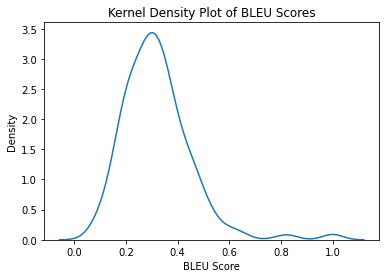

In [41]:
sns.kdeplot(processed['bleu'])
plt.xlabel("BLEU Score")
plt.title("Kernel Density Plot of BLEU Scores")
plt.show()